In [1]:
# import rozneho potrebneho...

%load_ext autoreload
%autoreload

%matplotlib nbagg

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

import sys
sys.path.append('./misc/')

from figFcns_nb import *

# O numerickom riešení diferenciálnych rovníc



Majme rovnicu opisujúcu dynamiku rotačného pohybu kyvadla. Rovnica je v tvare

$$
    ml^2 \ddot{\varphi}(t) + \beta \dot{\varphi}(t) + mgl\sin{\varphi(t)} = u(t)
$$

Samozrejme, ide o diferenciálnu rovnicu. Presnejšie o obyčajnú diferenciálnu rovnicu 2. rádu, ktorá je nehomogénna (vyskytuje sa v nej „externý signál“ (vstup)). Cieľom je nájsť numerické riešenie tejto rovnice pre dané začiatočné podmienky a pre prípadné dané vstupy (vstupné signály).



Pre úplnosť: kyvadlo je znázornené na nasledujúcom obrázku:
<img src="misc/obr_Kyvadlo.png" width="400px"/>
Hmotný bod s hmotnosťou $m$ [kg] pripevnený na ramene so zanedbateľnou hmotnosťou a dĺžkou $l$ [m] kmitá, $o$ označuje os otáčania kolmú na rovinu, v ktorej kyvadlo kmitá. Kmity sú tlmené viskóznym trením s koeficientom $\beta$ [kg m$^2$ s$^{-1}$]. Uhol medzi zvislicou a ramenom kyvadla je označený $\varphi$ [rad] a gravitačné zrýchlenie $g$ [m s$^{-2}$]. Signál $u(t)$ [kg m$^2$ s$^{-2}$] je externý moment sily pôsobiaci na rameno kyvadla, $\dot{\varphi}(t)$ [rad s$^{-1}$] je uhlová rýchlosť a $\ddot{\varphi}(t)$ [rad s$^{-2}$] je uhlové zrýchlenie ramena kyvadla. Číselné hodnoty parametrov kyvadla sú nasledovné:

In [2]:
m = 1.0
l = 1.0
g = 9.81
beta = 2 * 0.5 * np.sqrt(g/l)

Analytické riešenie diferenciálnej rovnice je v podstate nejaká funkcia času (a prípadne iných veličín). Numerické riešenie je postuppnosť hodnôt, číselných hodnôt, ktoré pri daných predpokladoch vyhovujú diferenciálnej rovnici. Je postupnosť hodnôt - vektor hodnôt, ku ktorému prislúcha časový vektor určujúci časovú postupnosť hodnôt numerického riešenia. Tu sme vynechali pár miliónov detailov, ale snáď sa dá vytušiť, čo sa tu myslí pod numerickým riešením.

## ODE solver

Pre hľadanie numerického riešenia využijeme ODE solver. ODE je skratka pre obyčajné diferenciálne rovnice (ordinary differential equation).

Úlohou ODE solvera je nájsť numerické riešenie na základe rovnice (diferenciálnej), ktorú je možné vo všeobecnosti zapísať v tvare

$$
    \dot x(t) = f \left( t, x(t), \ldots \right)
$$

kde $f$ je funkcia, ktorej argumenty sú čas $t$, prirodzene, samotný výstupný (hľadaný, neznámy) signál $x(t)$ a prípadne iné ďalšie parametre či veličiny - napríklad externý vstup. Uvedená rovnica doslova predpisuje aká je časová zmena signálu $x(t)$. Časová zmena signálu, inými slovami časová derivácia (derivácia podľa času) je označená ako $\dot x(t)$.

Ak teda do funkcie $f$ dosadíme hodnoty argumentov (čas, signál $x(t)$, a prípadne iné), získame hodnotu časovej zmeny $\dot x(t)$. Na základe informácie o $\dot x(t)$, ktorá zodpovedá aktuálnemu (dosadenému) signálu $x(t)$, môžeme určiť hodnotu $x(t)$ o nejaký čas neskôr. Túto novú hodnotu $x(t)$ možno opäť dosadiť do funkcie $f$ a následne nájsť ďalšiu ešte ďalej v čase - atď. ODE solver využíva práve tento jednoduchý princíp pre postupné hľadanie hodnôt (numerických hodnôt) signálu $x(t)$.

Vo všeobecnosti sa uvedený princíp nazýva numerická integrácia. ODE solver teda numericky integruje. Je množstvo metód pre numerickú integráciu, ktoré sa líšia spôsobom riešenia problémov súvisiacich so samotným procesom numerickej integrácie (voľba (optimalizácia) časového kroku integrácie, zohľadnenie matematických vlastností daného typu diferenciálnych rovníc a iné). ODE solvre sa môžu líšiť aj samotnou implementáciou niektorej z metód numerickej integrácie. Podrobnejší opis ODE solvera je nad rámec tohto textu.

## Rovnica vyššieho rádu ako sústava rovníc 1. rádu

ODE solverz princípu pracuje s diferenciálnou rovnicou prvého rádu, prípadne so sústavou diferenciálnych rovníc 1. rádu. Napríklad sústavu dvoch rovníc prvého rádu je možné vo všeobecnosti zapísať v tvare

$$
    \begin{bmatrix} \dot x_1(t) \\ \dot x_2(t) \end{bmatrix} = F \left( t, \begin{bmatrix} x_1(t) \\ x_2(t) \end{bmatrix}, \ldots \right)
$$

V našom prípade hľadáme riešenie pre rovnicu druhého rádu. Každú diferenciálnu rovnicu vyššieho rádu je možné zapísať ako sústavu rovníc prvého rádu. V taketo novej sústave rovníc, vo všeobecnosti, vznikli nové veličiny (signály), ktoré sa vo všeobecnosti môžu líšiť od pôvodných veličín (signálov) v pôvodnej rovnici vyššieho rádu.

Nové veličiny vystupujúce v sústave rovníc sa v teórii systémov súhrnne označujú ako stav systému (stavové veličiny systému). Ak poznáme aktuálny stav systému potom spravidla vieme určiť predchádzajúce aj budúce stavy (vo všeobecnosti).

Napr. v rovnici kyvadla vystupujú veličiny (signály) $\ddot \varphi(t)$, $\dot \varphi(t)$ a $\varphi(t)$. Je zrejmé (možno nie nad slnko jasné), že ako stav systému je možné zvoliť veličiny $\varphi(t)$ a $\dot \varphi(t)$, teda polohu a uhlovú rýchlosť kyvadla. Ak poznáme tieto, poznáme celú históriu a budúcnosť pohybu kyvadla.

Môže existovať viac možností voľby stavových veličín. Pri lineárnych systémoch je možností nekonečne veľa (nekonečne veľa stavových priestorov). Z praktického hľadiska však majú význam len niektoré voľby - napr. pri pohybových systémoch, akým je kyvadlo, sú to prirodzene polohy, rýchlosť, zrýchlenie, trh atď., v závislosti od rádu systému.

Jednou z možností ako previesť rovnicu vyššieho rádu na sústavu rovníc prvého rádu je nasledovný postup. V tomto prípade je zhodou okolností výsledkom aj prakticky využiteľný stavový priestor (stavovée veličiny $\varphi(t)$ a $\dot \varphi(t)$).

Nech
$$
x_1(t) = \varphi(t)
$$
potom
$$
\dot x_1(t) = \dot \varphi(t)
$$
Ďalej nech 
$$
\dot x_1(t) = \dot \varphi(t) = x_2(t)
$$
a to znamená, že
$$
\dot x_2(t) = \ddot \varphi(t)
$$
Tým sme získali veličiny $x_1(t) = \varphi(t)$ a $x_2(t) = \dot \varphi(t)$. Je možné zostaviť stavový vektor $x = \begin{bmatrix} x_1(t) & x_2(t) \end{bmatrix}^\mathsf T$ a teda $\dot x = \begin{bmatrix} \dot x_1(t) & \dot x_2(t) \end{bmatrix}^\mathsf T$.

Cieľom je konkretizovať funkciu $F$ v rovnici
$$
    \dot x = F(t, x, \ldots)
$$
čo je kompaktný zápis sústavy
$$
\begin{align}
    \dot x_1(t) &= F_1 \left(t, x_1(t), x_2(t), \ldots \right) \\
    \dot x_2(t) &= F_2 \left(t, x_1(t), x_2(t), \ldots \right)
\end{align}
$$

Prvú rovnicu v tomto prípade máme:
$$
    \dot x_1(t) = x_2(t)
$$
Druhá rovnica vyplynie z postrehu, že pôvodnú rovnicu druhého rádu možno zapísať v tvare
$$
\begin{align*}
    \ddot \varphi(t) &= -\frac{\beta}{ml^2}\dot\varphi(t) - \frac{g}{l} \sin\left( \varphi(t) \right) + \frac{1}{ml^2} u(t) \\
                     &= -\frac{\beta}{ml^2} x_2(t) - \frac{g}{l} \sin\left( x_1(t) \right) + \frac{1}{ml^2} u(t)
\end{align*}
$$
kde sú využité novo zavedené stavové veličiny $x_1(t)$ a $x_2(t)$. Je zrejmé, že druhá rovnica sústavy je
$$
    \dot x_2(t) = -\frac{\beta}{ml^2} x_2(t) - \frac{g}{l} \sin\left( x_1(t) \right) + \frac{1}{ml^2} u(t)
$$
a teda rovnice kyvadla v stavovom priestore sú
$$
    \begin{bmatrix} \dot x_1(t) \\ \dot x_2(t)  \end{bmatrix} = \begin{bmatrix} x_2(t) \\ -\frac{\beta}{ml^2} x_2(t) - \frac{g}{l} \sin\left( x_1(t) \right)  \end{bmatrix} + \begin{bmatrix} 0 \\ \frac{1}{ml^2} \end{bmatrix} u(t)
$$
čím je funkcia $F$ jasne stanovená (skonkretizovaná) a sústava spĺňa požiadanvky pre využitie v ODE solveri.

## Používanie ODE solvera

ODE solver ako funkcia v programe môže mať napríklad nasledujúce vstupy (argumenty) a výstupy:

```
x = odesolver(fcnF, init, timeVect)
```
kde `x` je, samozrejme, hľadané numerické riešenie. Prvým argumentom je funkcia, ktorá implementuje sústavu diferenciálnych rovníc v zmysle predchádzajúceho textu. `init` označuje začiatočné hodnoty stavových veličín. `timeVect` označuje časové okamihy (vzorky), v ktorých hľadáme hodnoty numerického riešenia.

Knižnica <a href="https://www.scipy.org/">SciPy</a>, presnejšie <a href="https://docs.scipy.org/doc/scipy-0.18.1/reference/integrate.html">scipy.integrate</a> obsahuje ODEsolver s názvom `odeint`. Vytvorme funkciu `fcnF` pre tento ODE solver:

In [3]:
def fcn_rovniceKyvadla(x, t, u):

    x_1, x_2 = x

    dotx_1 = x_2
    dotx_2 = -(beta/m*l**2) * x_2 - (g/l) * np.sin(x_1) + (1.0/m*l**2) * u

    return [dotx_1, dotx_2]

Vstupný externý moment sily uvažujme na teraz nulový:

In [4]:
u = 0

Definujme časový vektor, ktorý určí pre aké časové okamihy ODE solver vráti numerické riešenie:

In [5]:
timeVect = np.arange(0, 5.1, 0.1)

Zavolajme ODE solver, pričom ostáva zvoliť začiatočné podmienky - začiatočný stav kyvadla. Nech začiatočný stav je $x_1 = 0.25$ [rad] a $x_2 = 0$ [rad/s].

In [6]:
x = odeint(fcn_rovniceKyvadla,
           [0.25, 0],   # začiatočné podmienky
           timeVect,
           args=(u,),
           )

Premenná `x` teraz obsahuje dva stĺpce - prvý stĺpec (stĺpec číslo 0) je prvá stavová veličina a druhý stĺpec (stĺpec číslo 1) je druhá stavová veličina.

Nakreslime vypočítané riešenie:

<IPython.core.display.Javascript object>


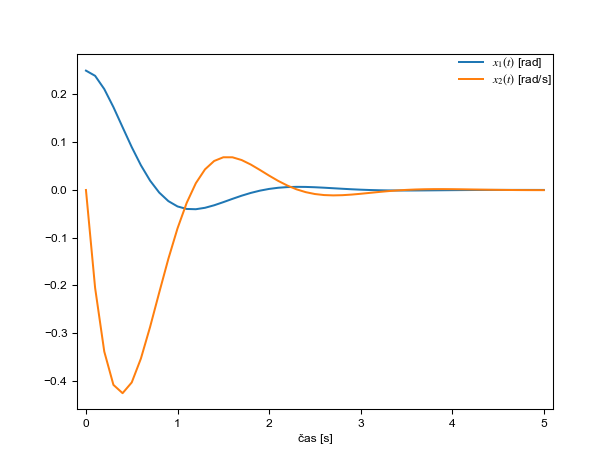

In [7]:
plt.figure(1)
plt.plot(timeVect, x)
plt.xlabel(u'čas [s]')
plt.legend(['$x_1(t)$ [rad]', '$x_2(t)$ [rad/s]'])

Nakreslime závislosť prvej stavovej veličiny (poloha kyvadla, alebo teda uhol kyvadla) od času, pričom prvú stavovú veličinu prepočítajme z radiánov na stupne:

<IPython.core.display.Javascript object>


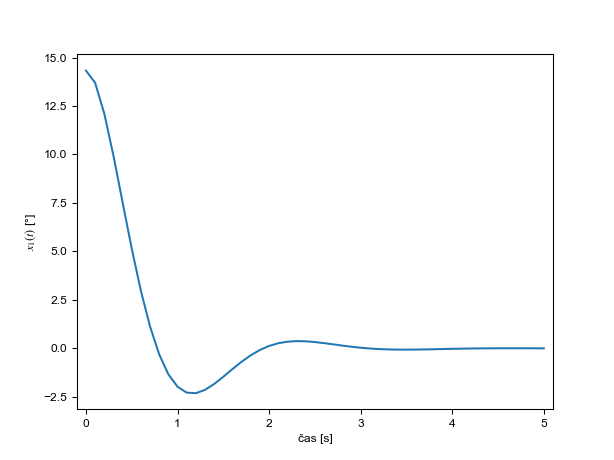

Text(0,0.5,u'$x_1(t)$ [\xb0]')

In [8]:
plt.figure(2)
plt.plot(timeVect, x[:,0]*180/np.pi)
plt.xlabel(u'čas [s]')
plt.ylabel(u'$x_1(t)$ [°]')

### Ďalšie pokusy...

Iné začiatočné podmienky:

<IPython.core.display.Javascript object>


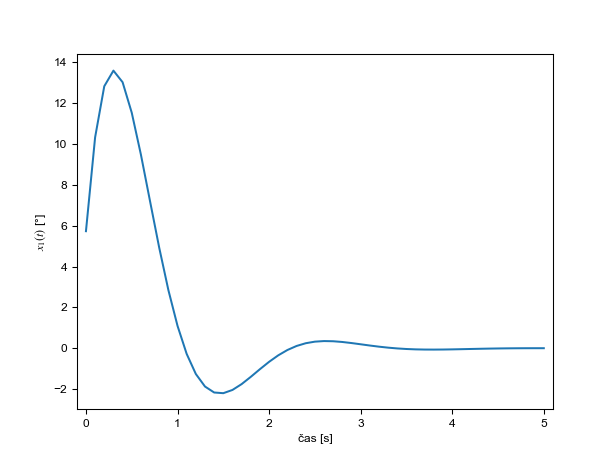

Text(0,0.5,u'$x_1(t)$ [\xb0]')

In [9]:
x = odeint(fcn_rovniceKyvadla,
           [0.1, 1],
           timeVect,
           args=(u,),
           )

plt.figure(3)
plt.plot(timeVect, x[:,0]*180/np.pi)
plt.xlabel(u'čas [s]')
plt.ylabel(u'$x_1(t)$ [°]')

...atď, ponecháva sa na čitateľa.

#### Nenulový vstup (externý moment sily)

Nech napríklad $u = 3$ [kg m$^2$ s$^{-2}$] (pozn.: pre lepšiu názornosť uvažujme začiatočné podmienky nulové).

<IPython.core.display.Javascript object>


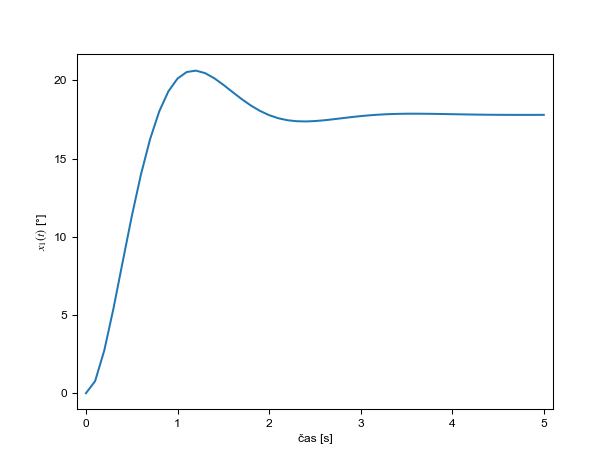

Text(0,0.5,u'$x_1(t)$ [\xb0]')

In [10]:
u = 3

x = odeint(fcn_rovniceKyvadla,
           [0, 0],
           timeVect,
           args=(u,),
           )

plt.figure(4)
plt.plot(timeVect, x[:,0]*180/np.pi)
plt.xlabel(u'čas [s]')
plt.ylabel(u'$x_1(t)$ [°]')

Zaujímavý prípad je, keď $u = 9,81$ [kg m$^2$ s$^{-2}$] 

<IPython.core.display.Javascript object>


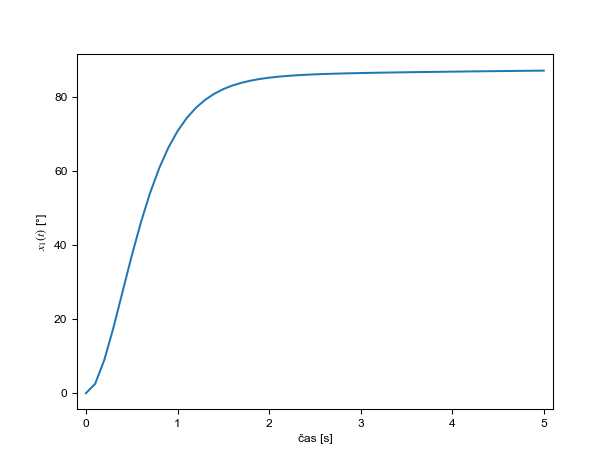

Text(0,0.5,u'$x_1(t)$ [\xb0]')

In [11]:
u = 9.81

x = odeint(fcn_rovniceKyvadla,
           [0, 0],
           timeVect,
           args=(u,),
           )

plt.figure(5)
plt.plot(timeVect, x[:,0]*180/np.pi)
plt.xlabel(u'čas [s]')
plt.ylabel(u'$x_1(t)$ [°]')

Avšak, lepšie sa to ukáže, ak predĺžime časový vektor (čas simulácie)

<IPython.core.display.Javascript object>


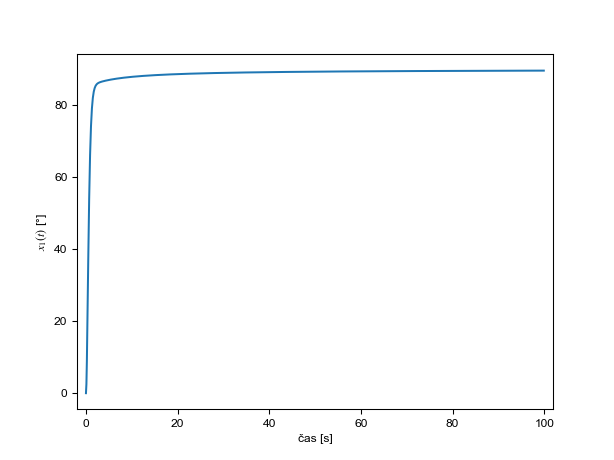

Text(0,0.5,u'$x_1(t)$ [\xb0]')

In [12]:
timeVect = np.arange(0, 100, 0.1)

x = odeint(fcn_rovniceKyvadla,
           [0, 0],
           timeVect,
           args=(u,),
           )

plt.figure(6)
plt.plot(timeVect, x[:,0]*180/np.pi)
plt.xlabel(u'čas [s]')
plt.ylabel(u'$x_1(t)$ [°]')

Čo sa stane ak $u = 9,82$ [kg m$^2$ s$^{-2}$]?

<IPython.core.display.Javascript object>


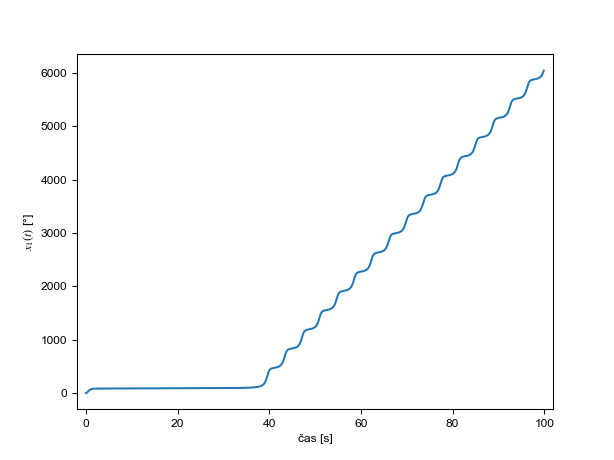

Text(0,0.5,u'$x_1(t)$ [\xb0]')

In [13]:
u = 9.82

x = odeint(fcn_rovniceKyvadla,
           [0, 0],
           timeVect,
           args=(u,),
           )

plt.figure(7)
plt.plot(timeVect, x[:,0]*180/np.pi)
plt.xlabel(u'čas [s]')
plt.ylabel(u'$x_1(t)$ [°]')

# O simulačnej schéme s využitím ODE solvera

Simulačnou schémou tu budeme nazývať ucelenú časť kódu, ktorá implementuje takpovediac simuláciu (numerickú simuláciu) nejakého dynamického systému spolu so vstupnými blokmi, s nastavením času, periódy vzorkovania, a podobne - teda tak ako by bola táto simulácia špecifikovaná „simulačnou schémou“, počasto graficky znázorňovanou pomocou základných blokov ako integrátor, násobička, sumátor atď (napr. ako sa to tiež používa v prostredí MATLAB-Simulink).

Nech simulačná schéma je programová funkcia, ktorá zrealizuje danú simuláciu, zaznamená veličiny podľa požiadaviek, prípadne iné hodnoty, a tieto nakoniec „vráti“ (budú výstupom programovej funkcie). 

Jednoduchá simulačná schéma pre simuláciu kyvadla by mohla vyzerať nasledovne:

In [14]:
def fcn_simSch01(t_start, t_final, T_s, u_tabulka):

    #-----------------------------------------
    # simulovat sa bude od casu t_start po t_final s periodou vzorkovania T_s
    # potom pocet „krokov“ (indexov), v ktorych ziskame „vysledok simulacie“ je:
    finalIndex = int(((t_final-t_start)/T_s) + 1)

    #-----------------------------------------
    # inicializacia vektora pre zapisovanie casu
    t_log = np.zeros([finalIndex, 1])
    t_log[0,:] = t_start

    #-----------------------------------------
    #Zaciatocne podmienky simulacie
    x_0 = np.zeros(2)

    #-----------------------------------------
    # inicializacia vektora pre zapisovanie stavoveho vektora dyn systemu
    x_log = np.zeros([finalIndex, len(x_0)])
    x_log[0,:] = x_0

    #-----------------------------------------
    # Generovanie vstupneho signalu:
    u = np.zeros(t_log.shape)

    for idx in range(u.shape[0]):
        lastValue = u_tabulka[:,1][u_tabulka[:,0]<=idx*T_s ][-1]
        u[idx] = lastValue


    #-----------------------------------------
    # Hlavny cyklus

    timespan = np.zeros(2)
    for idx in range(1, int(finalIndex)):

        timespan[0] = t_log[idx-1,:]
        timespan[1] = t_log[idx-1,:] + T_s

        odeOut = odeint(fcn_rovniceKyvadla,
                        x_log[idx-1,:],
                        timespan,
                        args=(u[idx-1,:],)
                        )

        x_log[idx,:] = odeOut[-1,:]
        t_log[idx,:] = timespan[-1]

    return [t_log, x_log, u]

Uvedená simulačná schéma umožňuje zadefinovať premenlivý signál $u(t)$ následne použitý počas simulácie. Predpokladá sa, že signál je daný tabuľkou, ktorá predpisuje, od ktorého času má signál danú hodnotu. Napríklad, ak od času 0 (od začiatku) má mať signál hodnotu 3 a potom od času 5 má mať signál hodnotu 7, potom „tabuľka“ (pole) vyzerá nasledovne:

In [15]:
u_tabulka = np.array([
                  [0, 3.0],
                  [5, 7.0],
                 ])

Smustime simuláciu so začiatkom v čase 0 do času 10 s periódou vzorkovania 0,1:

In [16]:
t_log, x_log, u = fcn_simSch01(0, 10, 0.1, u_tabulka)

Nakreslime výsledok:

<IPython.core.display.Javascript object>


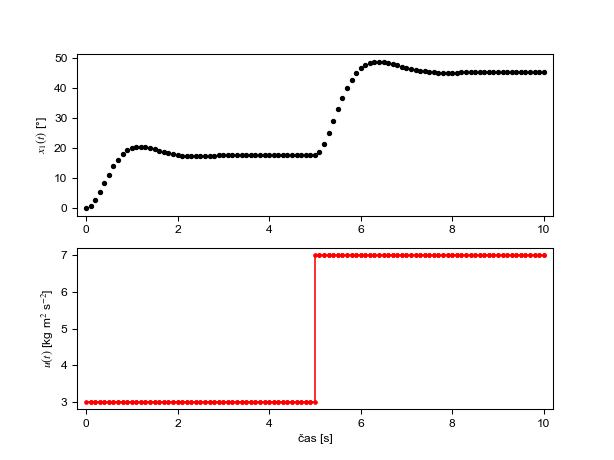

Text(0,0.5,u'$u(t)$ [kg m$^2$ s$^{-2}$]')

In [17]:
plt.figure(333)

plt.subplot(2,1,1)
plt.plot(t_log, x_log[:,0]*180/np.pi, '.k')
plt.ylabel(u'$x_1(t)$ [°]')

plt.subplot(2,1,2)
plt.plot(t_log, u,
         '.-r', lw=1.2, ms=5,
         drawstyle='steps-post',
         )
plt.xlabel(u'čas [s]')
plt.ylabel(u'$u(t)$ [kg m$^2$ s$^{-2}$]')